## Library import


In [23]:
from torch import nn as nn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,OrdinalEncoder,OneHotEncoder
from sklearn.impute import SimpleImputer
import torch
from fastai.learner import Learner
from fastai.metrics import accuracy
import warnings


In [24]:
# Ignore all warnings
warnings.filterwarnings('ignore')


## Feature Engineering

### train and validation data

In [26]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Load Titanic dataset (replace with your path or URL)
df = pd.read_csv('Titanic-Dataset.csv')

# 1. Select features and target
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'

X = df[features]
y = df[target]

# 2. Define preprocessing for numeric features
numeric_features = ['SibSp', 'Parch', 'Fare']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Fill missing with median
    ('scaler', StandardScaler())])                   # Scale to zero mean, unit variance

# 3. Define preprocessing for categorical features
categorical_features = ['Pclass', 'Sex', 'Embarked']
# Bin 'Age' into categories before categorical_transformer
# We'll add a new feature 'AgeBin' to X and treat it as categorical

# Bin Age into 5 bins (you can adjust bins as needed)
X['AgeBin'] = pd.cut(X['Age'], bins=[0, 12, 18, 35, 60, 100], labels=['Child', 'Teen', 'YoungAdult', 'Adult', 'Senior'])

X['IsFirstClass'] = (X['Pclass'] == 1).astype(int)

# 2. Create a new feature: IsThirdClass (1 if Pclass==3 else 0)
X['IsThirdClass'] = (X['Pclass'] == 3).astype(int)

# 3. Create an interaction feature: FarePerClass (Fare divided by Pclass)
X['FarePerClass'] = X['Fare'] / X['Pclass']

# 4. (Optional) One-hot encode Pclass if not already done
# This is often handled by the categorical transformer, but you can do it manually if needed:
# X = pd.get_dummies(X, columns=['Pclass'], prefix='Pclass')

# Remember to add any new features to your feature lists for preprocessing:
numeric_features += ['FarePerClass']


# Add 'AgeBin' to categorical features
categorical_features = [ 'Sex', 'Embarked', 'AgeBin']
categorical_features += ['IsFirstClass', 'IsThirdClass']

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Fill missing with mode
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])   # One-hot encode categories
# 4. Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# 5. Apply preprocessing to features
X_processed = preprocessor.fit_transform(X)

# 6. Optional: Split into train/test sets
x_train, x_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42)

print(f"Training samples: {x_train.shape[0]}, Test samples: {x_test.shape[0]}")


Training samples: 712, Test samples: 179


### Preparing Dataset

In [53]:
class TitanicDataset(Dataset):
    def __init__(self,x,y) -> None:
        super().__init__()
        self.x= torch.from_numpy(x).float()
        self.y = torch.from_numpy(y.values).float().unsqueeze(1)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        return self.x[index], self.y[index]  # ✅ tuple, not dict
 
from torch.utils.data import random_split

train_ds = TitanicDataset(x_train, y_train)
valid_ds = TitanicDataset(x_test, y_test)


train_dl = DataLoader(train_ds, batch_size=10)
valid_dl = DataLoader(valid_ds, batch_size=10)

from fastai.data.core import DataLoaders
dls = DataLoaders(train_dl, valid_dl)



## Model

### Model architecture

In [48]:
import torch.nn as nn

class TitanicModel(nn.Module):
   def __init__(self,feature_len):
        super().__init__()
        self.layers= nn.Sequential(
        nn.Linear(feature_len, 64),
        nn.BatchNorm1d(64),
        nn.ReLU(),
        nn.Dropout(0.3),

        nn.Linear(64, 32),
        nn.BatchNorm1d(32),
        nn.ReLU(),
        nn.Dropout(0.2),

        nn.Linear(32, 16),
        nn.ReLU(),

        nn.Linear(16, 1),
    
        )
   def forward(self,x,y=None):
       return self.layers(x)  
 

model = TitanicModel(18)

### Train

In [55]:
import mlflow
import mlflow.pytorch
from datetime import datetime
from torch.utils.tensorboard import SummaryWriter
mlflow.set_experiment("experiment_one")
run_name = f"Titanic_Torch_Run_{datetime.now().strftime('%Y%m%d_%H%M%S')}"


from fastai.callback.core import Callback


class MLFlowCallback(Callback):
    def __init__(self, writer=None):
        self.writer = writer

    def after_batch(self):
        # Epoch index
        epoch = self.epoch

        # Log weights, biases, and activations to TensorBoard and MLflow
        if hasattr(self.learn, 'model'):
            for name, param in self.learn.model.named_parameters():
                if param.requires_grad:
                    # Log weights
                    if self.writer:
                        self.writer.add_histogram(f"Weights/{name}", param.data.cpu().numpy(), epoch)
                   

        # Log activations (outputs of each layer) - only for the last batch in this epoch
        if hasattr(self.learn, 'model') and hasattr(self, 'last_input'):
            x = self.last_input
            activations = {}
            def save_activation(name):
                def hook(module, input, output):
                    activations[name] = output.detach().cpu()
                return hook

            handles = []
            for name, module in self.learn.model.named_modules():
                if isinstance(module, (nn.Linear, nn.ReLU, nn.BatchNorm1d, nn.Dropout)):
                    handles.append(module.register_forward_hook(save_activation(name)))
            with torch.no_grad():
                self.learn.model(x)
            for name, act in activations.items():
                if self.writer:
                    self.writer.add_histogram(f"Activations/{name}", act.numpy(), epoch)
                mlflow.log_artifact(
                    self._save_tensor_to_tempfile(act, f"{name}_activations_epoch{epoch}.pt")
                )
            for h in handles:
                h.remove()

        # valid_loss and metrics are in recorder.values
        if hasattr(self.learn.recorder, 'values') and self.learn.recorder.values:
            last_values = self.learn.recorder.values[-1]
            valid_loss = last_values[0]
            accuracy = last_values[1] if len(last_values) > 1 else None

            mlflow.log_metric("valid_loss", valid_loss, step=epoch)
            if accuracy is not None:
                mlflow.log_metric("accuracy", accuracy, step=epoch)

            if self.writer:
                self.writer.add_scalar("Loss/valid", valid_loss, epoch)
                if accuracy is not None:
                    self.writer.add_scalar("Accuracy/valid", accuracy, epoch)

        # Optionally log average training loss per epoch (approximate)
        if hasattr(self.learn.recorder, 'losses') and self.learn.recorder.losses:
            # Average over batches for this epoch
            # fastai doesn't expose clean epoch batch boundaries, so be cautious
            all_train_losses = [l.item() for l in self.learn.recorder.losses]
            avg_train_loss = sum(all_train_losses) / len(all_train_losses)

            mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
            if self.writer:
                self.writer.add_scalar("Loss/train", avg_train_loss, epoch)



with mlflow.start_run(run_name=run_name):
    mlflow.log_param("batch_size", 10)
    mlflow.log_param("epochs", 10)
    mlflow.log_param("learning_rate", 1e-3)
    mlflow.log_param("model_architecture", model)
    writer = SummaryWriter(log_dir=f"tensorboard_logs/{run_name}")
    
    learn = Learner(
        dls, 
        model, 
        loss_func=nn.BCEWithLogitsLoss(),
        metrics=accuracy,
        cbs=[MLFlowCallback(writer)]
    )
    learn.fit(10, lr=1e-3)
    mlflow.log_artifact(f"tensorboard_logs/{run_name}")


   

    input_example = np.random.randn(1, 18).astype(np.float32)
    mlflow.pytorch.log_model(model, "model", input_example=input_example)





epoch,train_loss,valid_loss,accuracy,time
0,0.503388,0.472819,0.586592,00:06
1,0.471411,0.456984,0.586592,00:08
2,0.451406,0.457511,0.586592,00:07
3,0.427811,0.447177,0.586592,00:09
4,0.421740,0.445464,0.586592,00:09
5,0.420789,0.445401,0.586592,00:11
6,0.407935,0.450827,0.586592,00:12
7,0.402462,0.455859,0.586592,00:15
8,0.394417,0.446873,0.586592,00:14
9,0.398640,0.450556,0.586592,00:13


2025/06/28 22:44:12 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
2025/06/28 22:44:12 WARNING mlflow.models.signature: Failed to infer the model signature from the input example. Reason: RuntimeError('Tensor for argument input is on cpu but expected on mps'). To see the full traceback, set the logging level to DEBUG via `logging.getLogger("mlflow").setLevel(logging.DEBUG)`.
2025/06/28 22:44:19 WARNING mlflow.models.model: Failed to validate serving input example {
  "inputs": [
    [
      0.2042083889245987,
      -1.6300134658813477,
      -1.229819655418396,
      0.03173350170254707,
      0.3540950417518616,
      -0.7485231161117554,
      -0.057413920760154724,
      -1.3310774564743042,
      -0.7293691635131836,
      -0.49474436044692993,
      -0.08568935096263885,
      2.034656047821045,
      -1.0346598625183105,
      0.5188901424407959,
      0.8094419240951538,
      -1.4632961750030518,
      -1.2895830869674683,
      -1.01942

## EVALUATION


### SCORES


#### METRICS

In [56]:
 # Convert torch tensors to numpy arrays for sklearn


from sklearn.metrics import accuracy_score, roc_auc_score
 
preds, targets = learn.get_preds(dl=valid_dl)
probs = preds.sigmoid()
pred_classes = (probs > 0.5).int()


y_true = targets.numpy().astype(int).flatten()
y_pred = pred_classes.numpy().flatten()

val_acc = accuracy_score(y_true, y_pred)
val_auc = roc_auc_score(y_true, probs.numpy().flatten())

mlflow.log_metric("val_accuracy", val_acc)
mlflow.log_metric("val_auc", val_auc)
# Register the trained model in MLflow with input_example for signature inference

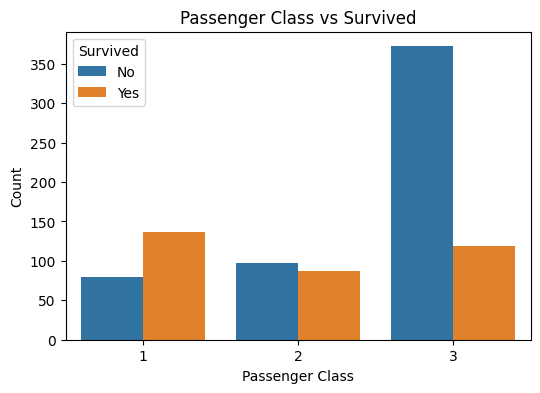

SettingWithCopyError: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

In [58]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot Passenger Class vs Survived
plt.figure(figsize=(6,4))
sns.countplot(x='Pclass', hue='Survived', data=df)
plt.title('Passenger Class vs Survived')
plt.xlabel('Passenger Class')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['No', 'Yes'])
plt.show()

# --- Feature Engineering Suggestion for Passenger Class ---

# 1. Create a new feature: IsFirstClass (1 if Pclass==1 else 0)
X['IsFirstClass'] = (X['Pclass'] == 1).astype(int)

# 2. Create a new feature: IsThirdClass (1 if Pclass==3 else 0)
X['IsThirdClass'] = (X['Pclass'] == 3).astype(int)
import io
import mlflow

# Save the plot to a buffer
buf = io.BytesIO()
plt.savefig(buf, format='png')
buf.seek(0)

# Log the plot as an artifact in mlflow
mlflow.set_experiment("experiment_one")
with mlflow.start_run():
    mlflow.log_figure(plt.gcf(), "passenger_class_vs_survived.png")

buf.close()# Get predictions and targets on validation set
preds, targets = learn.get_preds(dl=train_dl)

# preds are raw logits, convert to probabilities
probs = preds.sigmoid()

# Convert probabilities to binary classes (0 or 1)
pred_classes = (probs > 0.5).int()
from sklearn.metrics import accuracy_score

# Convert torch tensors to numpy arrays for sklearn
y_true = targets.numpy().astype(int).flatten()
y_pred = pred_classes.numpy().flatten()

acc = accuracy_score(y_true, y_pred)
print("Validation Accuracy:", acc)





#### Precision recall curve

Validation Accuracy: 0.8398876404494382
Best threshold by Youden's J statistic: 0.4387
At this threshold: TPR=0.7201, FPR=0.0788


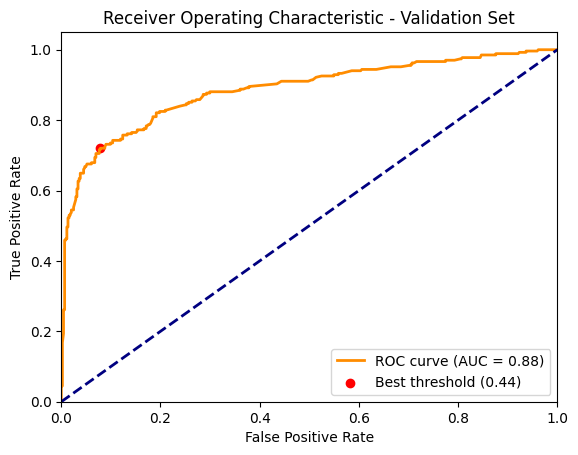

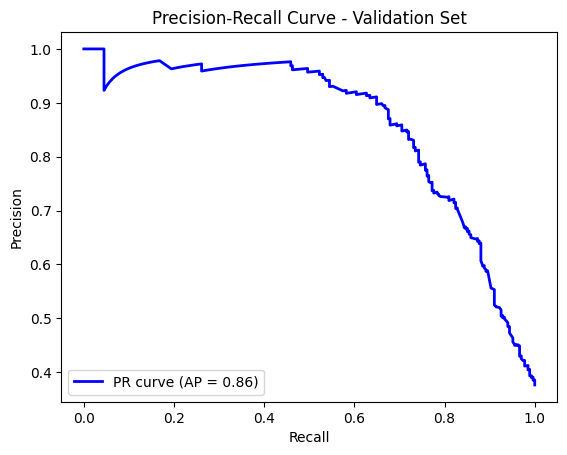

TensorBoard is not supported on Python 3.13 due to missing 'imghdr'. Use Python 3.12 or lower for TensorBoard support.


In [60]:
# Get predictions and targets on validation set
preds, targets = learn.get_preds(dl=train_dl)

# preds are raw logits, convert to probabilities
probs = preds.sigmoid()

# Convert probabilities to binary classes (0 or 1)
pred_classes = (probs > 0.5).int()
from sklearn.metrics import accuracy_score

# Convert torch tensors to numpy arrays for sklearn
y_true = targets.numpy().astype(int).flatten()
y_pred = pred_classes.numpy().flatten()

acc = accuracy_score(y_true, y_pred)
print("Validation Accuracy:", acc)
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_true, probs.numpy().flatten())
roc_auc = auc(fpr, tpr)


# fpr stands for "False Positive Rate" and tpr stands for "True Positive Rate".
# 
# - False Positive Rate (fpr): This is the proportion of actual negatives that are incorrectly classified as positives. 
#   It is calculated as: fpr = FP / (FP + TN), where FP is the number of false positives and TN is the number of true negatives.
#
# - True Positive Rate (tpr): This is also known as "Recall" or "Sensitivity". It is the proportion of actual positives that are correctly identified.
#   It is calculated as: tpr = TP / (TP + FN), where TP is the number of true positives and FN is the number of false negatives.
#
# In the context of the ROC curve, fpr and tpr are computed at various threshold settings to evaluate the performance of a binary classifier.
# The "best" threshold on the ROC curve depends on your specific goal (e.g., maximizing accuracy, recall, or balancing both).
# A common approach is to choose the threshold that gives the best balance between true positive rate (tpr) and false positive rate (fpr).
# One way to do this is to maximize the Youden's J statistic: J = tpr - fpr

# Find the threshold that maximizes tpr - fpr
j_scores = tpr - fpr
best_idx = j_scores.argmax()
best_threshold = thresholds[best_idx]
print(f"Best threshold by Youden's J statistic: {best_threshold:.4f}")
print(f"At this threshold: TPR={tpr[best_idx]:.4f}, FPR={fpr[best_idx]:.4f}")

# Optionally, plot the chosen threshold on the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.scatter(fpr[best_idx], tpr[best_idx], color='red', label=f'Best threshold ({best_threshold:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Validation Set')
plt.legend(loc="lower right")
plt.show()
from sklearn.metrics import precision_recall_curve, average_precision_score

# Compute precision-recall curve and average precision
precision, recall, pr_thresholds = precision_recall_curve(y_true, probs.numpy().flatten())
avg_precision = average_precision_score(y_true, probs.numpy().flatten())

# Plot the Precision-Recall curve
plt.figure()
plt.plot(recall, precision, color='blue', lw=2, label=f'PR curve (AP = {avg_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Validation Set')
plt.legend(loc="lower left")
plt.show()

# TensorBoard failed to launch due to a missing 'imghdr' module in Python 3.13.
# This is a known issue because 'imghdr' was removed in Python 3.13.
# 
# Workarounds:
# 1. Downgrade to Python 3.12 or lower, where 'imghdr' is available.
# 2. Wait for TensorBoard to release a version compatible with Python 3.13.
# 3. If you only need scalar plots (not images), you can use matplotlib or other logging tools.

# Example: Visualize training/validation loss with matplotlib (as a workaround)
# plt.plot(train_losses, label='Train Loss')
# plt.plot(val_losses, label='Validation Loss')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.legend()
# plt.show()

# If you still want to try launching TensorBoard (and have downgraded Python), use:
# %load_ext tensorboard
# %tensorboard --logdir runs

# For now, TensorBoard is not supported on Python 3.13 due to the missing 'imghdr' module.
print("TensorBoard is not supported on Python 3.13 due to missing 'imghdr'. Use Python 3.12 or lower for TensorBoard support.")

